In [58]:
import pandas as pd
import numpy as np
from rdkit import Chem
from rdkit.Chem import AllChem ,MolStandardize
from torch.utils.data import Dataset, DataLoader, TensorDataset
from torchvision import transforms
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
from rdkit import RDLogger
RDLogger.DisableLog('rdApp.*')

import os
if not os.path.exists('models'):
    os.makedirs('models')

In [59]:
# Load the dataset
df = pd.read_csv('BBBP.csv')
df = df.sort_values(by='p_np', ascending=False)
df = df.sample(frac=1, random_state=42)
# Display the first few rows of the dataset
df.head()


,num,name,p_np,smiles
775,777,cefminox,0,CO[C@]1(NC(=O)CSC[C@@H](N)C(O)=O)[C@H]2SCC(=C(...
2030,2034,tuclazepam,1,C1=C2C(=CC=C1)N(C(Cl)(CN=C2C3=CC=CC=C3Cl)CO)C
1753,1757,citalopram,1,C1=CC(=CC3=C1C(C2=CC=C(F)C=C2)(OC3)CCCN(C)C)C#N
1889,1893,medifoxamine,1,C2=C(OC(OC1=CC=CC=C1)CN(C)C)C=CC=C2
425,427,Triamterene,0,Nc1nc(N)c2nc(c3ccccc3)c(N)nc2n1


### The Simplified Molecular Input Line Entry System (SMILES) is a linear notation method used to represent chemical compounds uniquely in the form of strings over a fixed alphabet
In the context of deep learning, SMILES is often used as a character-based approach, inspired by natural language processing techniques
SMILES strings can be converted into tensors for training deep learning models
This conversion is facilitated by tokenization, where SMILES strings are split into lists of tokens. These tokens are then encoded using a vocabulary that translates between the tokens and integers

In this work, I tokenized atoms + all other characters used in dataset into one-hot vectors. This mean sometimes I tokenized 2 characters as a token when it represents an atom like Cl, Br, etc.

count    2050.000000
mean       51.474146
std        30.620659
min         3.000000
25%        33.000000
50%        45.000000
75%        61.000000
max       400.000000
Name: smiles_length, dtype: float64


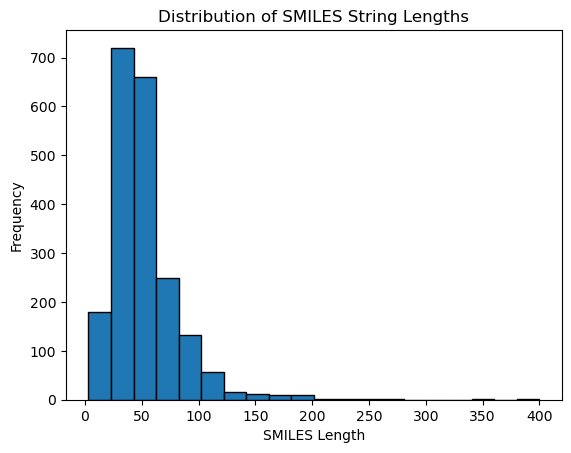

In [60]:
# Calculate the lengths of SMILES strings
df['smiles_length'] = df['smiles'].apply(len)

# Display basic statistics of the lengths
print(df['smiles_length'].describe())

# Plot histogram of lengths
plt.hist(df['smiles_length'], bins=20, edgecolor='black')
plt.title('Distribution of SMILES String Lengths')
plt.xlabel('SMILES Length')
plt.ylabel('Frequency')
plt.show()


As we can see, max length of SMILES code available in dataset is 400, but there is a few molecules with more than 200 length, I decided to remove bigger molecules as outliers to improve model accuracy because they cause big paddings and this can affect LSTM behavior.

In [61]:
df = df[df["smiles_length"] <= 200]  # Removing outliars!

count    2043.000000
mean       50.709251
std        27.441232
min         3.000000
25%        33.000000
50%        45.000000
75%        61.000000
max       200.000000
Name: smiles_length, dtype: float64


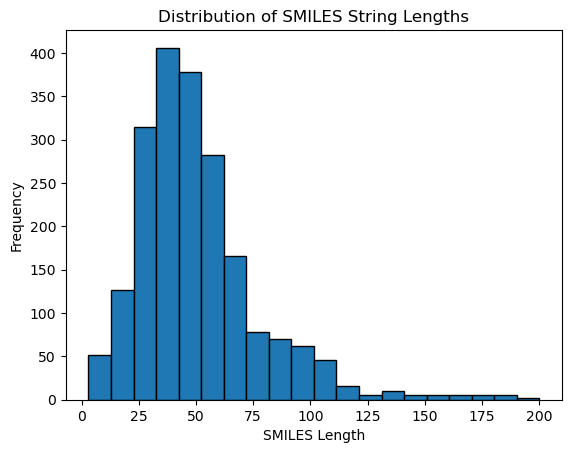

In [62]:
# Calculate the lengths of SMILES strings
df['smiles_length'] = df['smiles'].apply(len)

# Display basic statistics of the lengths
print(df['smiles_length'].describe())

# Plot histogram of lengths
plt.hist(df['smiles_length'], bins=20, edgecolor='black')
plt.title('Distribution of SMILES String Lengths')
plt.xlabel('SMILES Length')
plt.ylabel('Frequency')
plt.show()

Now its more acceptable distribution. 

## Functions

In [63]:
# Function to get unique tokens from SMILES strings
def get_unique_tokens(smiles_list):
    tokens = set()
    for smiles in smiles_list:
        if smiles:
            mol = Chem.MolFromSmiles(smiles)
            if mol:
                tokens.update([atom.GetSymbol() for atom in mol.GetAtoms()])
    return tokens

# Make smiles standard in a unique style
def standardize_smiles(smiles_list):
    standardized_smiles = []
    
    for smiles in smiles_list:
        mol = Chem.MolFromSmiles(smiles)
        
        if mol is not None:
            standardized_smiles.append(Chem.MolToSmiles(mol))

        else:
            # Handle invalid SMILES
            standardized_smiles.append(None)
    
    return standardized_smiles

# tokenize data with dictionary(unique_tokens)
def tokenize(input_string, dict):
    tokens = []

    while len(input_string) > 0:
        char_now = input_string[0]
        if len(input_string) > 1:
            char_next = input_string[1]

            if char_now + char_next in dict:
                tokens.append(char_now + char_next)
                input_string = input_string[2:]

        if char_now in dict:
            tokens.append(char_now)
            input_string = input_string[1:]
        else :
            raise ValueError(f'The character {char_now} was not in the dict!\ndict={dict}')

    return [dict.index(i)+1 for i in tokens]

### Finding unique tokens used in dataset and extraction of token dictionary

In [64]:
# Get unique tokens and modify dataframe
standard_list = standardize_smiles(df['smiles'])
unique_Atoms = sorted(list(get_unique_tokens(standard_list)), key=len, reverse=True)

# Mask dataframe to standard and correct values
mask = np.array(standard_list) == None
df = df[~mask]

mystr = ''.join(df["smiles"].values)
for i in unique_Atoms:
    mystr = mystr.replace(i, '')
unique_tokens = unique_Atoms + sorted(list(set(mystr)))[::-1]

max_length = 0
min_length = np.inf
for i in df["smiles"]:
    max_length = max(max_length, len(tokenize(i, unique_tokens)))
    min_length = min(min_length, len(tokenize(i, unique_tokens)))

print("Unique Atoms:", unique_Atoms)
print("Number of Unique Atoms:", len(unique_Atoms))

print('Unique Tokens:', unique_tokens)
print('Number of Unique Tokens:', len(unique_tokens))

print("Maximum embedding length with this tokens:", max_length)
print("Minimum embedding length with this tokens:", min_length)

Unique Atoms: ['Ca', 'Br', 'Cl', 'Na', 'F', 'P', 'H', 'I', 'B', 'O', 'N', 'S', 'C']
Number of Unique Atoms: 13
Unique Tokens: ['Ca', 'Br', 'Cl', 'Na', 'F', 'P', 'H', 'I', 'B', 'O', 'N', 'S', 'C', 's', 'o', 'n', 'c', ']', '\\', '[', '@', '=', '9', '8', '7', '6', '5', '4', '3', '2', '1', '0', '/', '.', '-', '+', ')', '(', '%', '#']
Number of Unique Tokens: 40
Maximum embedding length with this tokens: 200
Minimum embedding length with this tokens: 3


### Dataset/Dataloader and model implementation

As we can see above, maximum tokenized embedding length is 200 (outliers removed) so I used two sided padding for pad embeddings with less than 200 length to centralize information in the input tensor

In [65]:
class MoleculeDataset(Dataset):

    def __init__(self, dataframe, tokens, max_length):
        
        smiles_list = dataframe["smiles"].values
        p_np = dataframe["p_np"].values

        self.LSTM = False
        self.lengths = False
        self.seqs = []
        self.labels = []
        self.max_length = max_length
        self.len_tokens = len(tokens)
        self.actual_lengths = []
        for j, smiles in enumerate(smiles_list):
            tokenized = tokenize(smiles, tokens)
            self.actual_lengths.append(len(tokenized))
            tokenized = [0] * ((max_length - len(tokenized))//2) + tokenized
            tokenized += [0] * (max_length - len(tokenized))
            self.seqs.append(tokenized)
            self.labels.append(p_np[j])
        
    

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        
        if self.LSTM:
            # mol_tensor = torch.tensor(self.seqs[idx]).view(-1, self.word_size).float()
            tokenized = torch.nn.functional.one_hot(torch.tensor(self.seqs[idx]), num_classes=self.len_tokens+1)
            mol_tensor = tokenized[:, 1:]
            mol_tensor = mol_tensor.reshape(-1, self.len_tokens * self.word_size).float()
        else :
            tokenized = torch.nn.functional.one_hot(torch.tensor(self.seqs[idx]), num_classes=self.len_tokens+1)
            mol_tensor = torch.flatten(tokenized[:, 1:]).float()
        label = self.labels[idx]
        
        if self.lengths:
            return mol_tensor, label, self.actual_lengths[idx]
        else:
            return mol_tensor, label
    def LSTMMode(self, word_size):
        self.LSTM = True
        self.word_size = word_size
        
    def fcMode(self):
        self.LSTM = False


In [66]:


# Define the model
class FCNet(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(FCNet, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden_size[0])
        self.relu1 = nn.ReLU()
        self.fc2 = nn.Linear(hidden_size[0], hidden_size[1])
        self.relu2 = nn.ReLU()
        self.fc3 = nn.Linear(hidden_size[1], output_size)
        self.softmax = nn.Softmax(dim=1)

    def forward(self, x):
        x = self.fc1(x)
        x = self.relu1(x)
        x = self.fc2(x)
        x = self.relu2(x)
        x = self.fc3(x)
        x = self.softmax(x)
        return x

In [67]:
# Split the dataset into train, validation, and test sets
train_data, temp_data = train_test_split(df, test_size=0.3, random_state=42)
val_data, test_data = train_test_split(temp_data, test_size=0.5, random_state=42)

# Create dataset objects
train_dataset = MoleculeDataset(train_data, unique_tokens, max_length)
val_dataset = MoleculeDataset(val_data, unique_tokens, max_length)
test_dataset = MoleculeDataset(test_data, unique_tokens, max_length)

# Create DataLoader objects

batch_size = 64  # Adjust as needed
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

### Training(FC model)

In [68]:
train_dataset.fcMode()
val_dataset.fcMode()
test_dataset.fcMode()
# Define the input size, hidden size, and output size
input_size = train_dataset[0][0].shape[0]
hidden_size = 256, 32
output_size = 2  # Binary classification

device = 'cuda' if torch.cuda.is_available() else 'cpu'
# Create the model, loss function, and optimizer
model = FCNet(input_size, hidden_size, output_size).to(device)
criterion = nn.BCELoss()
optimizer = optim.Adam(model.parameters())


Epoch [1/10] - Train Loss: 0.6228, Train Accuracy: 57.10%, Validation Loss: 0.4259, Validation Accuracy: 81.31%
Epoch [2/10] - Train Loss: 0.3698, Train Accuracy: 82.70%, Validation Loss: 0.3444, Validation Accuracy: 81.64%
Epoch [3/10] - Train Loss: 0.2357, Train Accuracy: 90.44%, Validation Loss: 0.3576, Validation Accuracy: 83.28%
Epoch [4/10] - Train Loss: 0.1441, Train Accuracy: 94.66%, Validation Loss: 0.4493, Validation Accuracy: 82.30%
Epoch [5/10] - Train Loss: 0.0916, Train Accuracy: 97.12%, Validation Loss: 0.5110, Validation Accuracy: 83.28%
Epoch [6/10] - Train Loss: 0.0533, Train Accuracy: 98.52%, Validation Loss: 0.6072, Validation Accuracy: 83.61%
Epoch [7/10] - Train Loss: 0.0337, Train Accuracy: 99.30%, Validation Loss: 0.7297, Validation Accuracy: 83.61%
Epoch [8/10] - Train Loss: 0.0184, Train Accuracy: 99.72%, Validation Loss: 0.8100, Validation Accuracy: 83.28%
Epoch [9/10] - Train Loss: 0.0122, Train Accuracy: 99.86%, Validation Loss: 0.8928, Validation Accuracy:

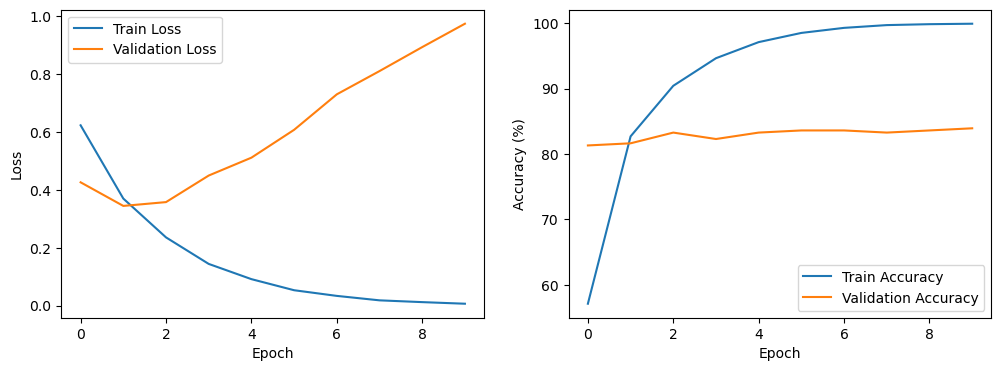

In [69]:

num_epochs = 10
train_losses = []
train_accuracies = []
val_losses = []
val_accuracies = []

for epoch in range(num_epochs):
    model.train()
    total_train_loss = 0.0
    correct_train = 0
    total_train = 0

    for seqs, labels in train_loader:
        seqs, labels = seqs.to(device), labels.to(device)
        labels_softmax = torch.cat([labels.view(-1, 1)==0, labels.view(-1, 1)==1], dim=1).float()
        optimizer.zero_grad()
        outputs = model(seqs)
        loss = criterion(outputs, labels_softmax)
        loss.backward()
        optimizer.step()

        total_train_loss += loss.item()
        _, predicted = outputs.max(1)
        total_train += labels.size(0)
        correct_train += predicted.eq(torch.argmax(labels_softmax, dim=1)).sum().item()

    train_accuracy = 100 * correct_train / total_train
    avg_train_loss = total_train_loss / len(train_loader)
    train_losses.append(avg_train_loss)
    train_accuracies.append(train_accuracy)

    

    model.eval()
    total_val_loss = 0.0
    correct_val = 0
    total_val = 0

    with torch.no_grad():
        for seqs, labels in val_loader:
            seqs, labels = seqs.to(device), labels.to(device)
            labels_softmax = torch.cat([labels.view(-1, 1)==0, labels.view(-1, 1)==1], dim=1).float()
            val_outputs = model(seqs)
            val_loss = criterion(val_outputs, labels_softmax)

            total_val_loss += val_loss.item()
            _, predicted_val = val_outputs.max(1)
            total_val += labels.size(0)
            correct_val += predicted_val.eq(torch.argmax(labels_softmax, dim=1)).sum().item()

    val_accuracy = 100 * correct_val / total_val
    avg_val_loss = total_val_loss / len(val_loader)
    val_losses.append(avg_val_loss)
    val_accuracies.append(val_accuracy)

    if (100 * (epoch+1) / num_epochs) % 10 == 0:
        print(f"Epoch [{epoch + 1}/{num_epochs}] - "
            f"Train Loss: {avg_train_loss:.4f}, "
            f"Train Accuracy: {train_accuracy:.2f}%, "
            f"Validation Loss: {avg_val_loss:.4f}, "
            f"Validation Accuracy: {val_accuracy:.2f}%")
    torch.save(model, f'./models/FCmodel_{epoch+1}.pth')

# Plotting
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(train_accuracies, label='Train Accuracy')
plt.plot(val_accuracies, label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.legend()

plt.show()


In [71]:
# Evaluate the model
best_model = torch.load('./models/FCmodel_3.pth').to(device)
torch.save(best_model, 'best_model_fc.pth')
best_model.eval()
with torch.no_grad():

    accuracy = 0
    for seqs, labels in test_loader:
        seqs, labels = seqs.to(device), labels.to(device)
        test_outputs = best_model(seqs)
        predicted_labels = torch.argmax(test_outputs, axis=1)
    
        accuracy += torch.sum(predicted_labels == labels).item() / len(labels) / len(test_loader)
    print("Accuracy on the test data:", f'{accuracy*100:.2f}')

Accuracy on the test data: 87.26


### LSTM model implementation

In [12]:
class LSTMNet(nn.Module):
    def __init__(self, input_size, hidden_size, output_size, num_layers, max_length, word_size=1, bi=False, dropout=0.5):
        super(LSTMNet, self).__init__()
        self.lstm1 = nn.LSTM(input_size, hidden_size[0], num_layers, batch_first=True, bidirectional=bi)
        self.lstm2 = nn.LSTM(input_size, hidden_size[0], num_layers, batch_first=True, bidirectional=bi)
        self.flatten = nn.Flatten()
        self.dropout_rate = dropout
        self.dropout = nn.Dropout(dropout)
        self.fc1 = nn.Linear(hidden_size[0] * max_length//word_size * (1 + bi) * 2, hidden_size[1])
        self.batchnorm1 = nn.BatchNorm1d(hidden_size[1])
        self.relu = nn.ReLU()
        self.fc2 = nn.Linear(hidden_size[1], output_size)
        self.softmax = nn.Softmax(dim=-1)

    def forward(self, x):
        if len(x.shape) < 3:
            x = x.unsqueeze(0)
        lstm_out1, _ = self.lstm1(x)
        lstm_out2, _ = self.lstm2(x)
        x = torch.cat([lstm_out1, lstm_out2], dim=-1)
        x = self.flatten(x)

        if self.dropout_rate > 0:
            x = self.dropout(x)

        x = self.fc1(x)
        x = self.batchnorm1(x)
        x = self.relu(x)
        x = self.fc2(x)
        x = self.softmax(x)
        return x


### Training(LSTM)

In [18]:
torch.manual_seed(42)
device = 'cuda' if torch.cuda.is_available() else 'cpu'

num_layers = 1
word_size = 1
input_size = len(unique_tokens) * word_size
hidden_size = 4, 256
output_size = 2


train_dataset.LSTMMode(word_size)
val_dataset.LSTMMode(word_size)
test_dataset.LSTMMode(word_size)

batch_size = 1422  # Adjust as needed
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

model = LSTMNet(input_size, hidden_size, output_size, num_layers, max_length, word_size).to(device)
criterion = nn.BCELoss()
optimizer = optim.Adam(model.parameters(), lr=0.0013)

Epoch [50/500] - Train Loss: 0.3473, Train Accuracy: 84.81%, Validation Loss: 0.4133, Validation Accuracy: 82.62%
Epoch [100/500] - Train Loss: 0.2467, Train Accuracy: 89.59%, Validation Loss: 0.3829, Validation Accuracy: 83.93%
Epoch [150/500] - Train Loss: 0.1643, Train Accuracy: 92.83%, Validation Loss: 0.3718, Validation Accuracy: 82.62%
Epoch [200/500] - Train Loss: 0.0967, Train Accuracy: 96.55%, Validation Loss: 0.3721, Validation Accuracy: 84.92%
Epoch [250/500] - Train Loss: 0.0520, Train Accuracy: 98.45%, Validation Loss: 0.4093, Validation Accuracy: 85.25%
Epoch [300/500] - Train Loss: 0.0271, Train Accuracy: 99.44%, Validation Loss: 0.4005, Validation Accuracy: 87.21%
Epoch [350/500] - Train Loss: 0.0205, Train Accuracy: 99.58%, Validation Loss: 0.4034, Validation Accuracy: 87.87%
Epoch [400/500] - Train Loss: 0.0138, Train Accuracy: 99.86%, Validation Loss: 0.4124, Validation Accuracy: 89.18%
Epoch [450/500] - Train Loss: 0.0097, Train Accuracy: 99.86%, Validation Loss: 0.

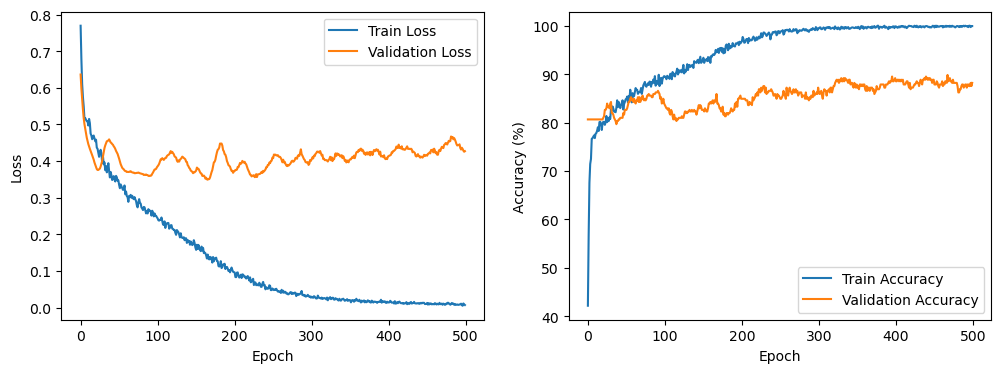

In [19]:
num_epochs = 500
train_losses = []
train_accuracies = []
val_losses = []
val_accuracies = []


for epoch in range(num_epochs):
    model.train()
    total_train_loss = 0.0
    correct_train = 0
    total_train = 0

    for seqs, labels in train_loader:
        seqs, labels = seqs.to(device), labels.to(device)
        labels_softmax = torch.cat([labels.view(-1, 1)==0, labels.view(-1, 1)==1], dim=1).float()
        optimizer.zero_grad()
        outputs = model(seqs)
        loss = criterion(outputs, labels_softmax)
        loss.backward()
        optimizer.step()

        total_train_loss += loss.item()
        _, predicted = outputs.max(1)
        total_train += labels.size(0)
        correct_train += predicted.eq(torch.argmax(labels_softmax, dim=1)).sum().item()

    train_accuracy = 100 * correct_train / total_train
    avg_train_loss = total_train_loss / len(train_loader)
    train_losses.append(avg_train_loss)
    train_accuracies.append(train_accuracy)

    

    model.eval()
    total_val_loss = 0.0
    correct_val = 0
    total_val = 0

    with torch.no_grad():
        for seqs, labels in val_loader:
            seqs, labels = seqs.to(device), labels.to(device)
            labels_softmax = torch.cat([labels.view(-1, 1)==0, labels.view(-1, 1)==1], dim=1).float()
            val_outputs = model(seqs + torch.randn_like(seqs)/200)
            val_loss = criterion(val_outputs, labels_softmax)

            total_val_loss += val_loss.item()
            _, predicted_val = val_outputs.max(1)
            total_val += labels.size(0)
            correct_val += predicted_val.eq(torch.argmax(labels_softmax, dim=1)).sum().item()

    val_accuracy = 100 * correct_val / total_val
    avg_val_loss = total_val_loss / len(val_loader)
    val_losses.append(avg_val_loss)
    val_accuracies.append(val_accuracy)

    if (100 * (epoch+1) / num_epochs) % 10 == 0:
        print(f"Epoch [{epoch + 1}/{num_epochs}] - "
            f"Train Loss: {avg_train_loss:.4f}, "
            f"Train Accuracy: {train_accuracy:.2f}%, "
            f"Validation Loss: {avg_val_loss:.4f}, "
            f"Validation Accuracy: {val_accuracy:.2f}%")
    torch.save(model, f'./models/LSTMmodel_{epoch+1}.pth')

# Plotting
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(train_accuracies, label='Train Accuracy')
plt.plot(val_accuracies, label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.legend()

plt.show()


In [22]:
# Evaluate the model

best_model = torch.load(f'./models/LSTMmodel_170.pth').to(device)
torch.save(best_model, 'best_model_LSTM.pth')
best_model.eval()
with torch.no_grad():

    accuracy = 0
    for seqs, labels in test_loader:
        seqs, labels = seqs.to(device), labels.to(device)
        test_outputs = best_model(seqs)
        predicted_labels = torch.argmax(test_outputs, axis=1)
        
        accuracy += torch.sum(predicted_labels == labels).item() / len(labels) / len(test_loader)
    print("Accuracy on the test data:", f'{accuracy*100:.2f}')
    


Accuracy on the test data: 90.05


### Training(BiLSTM)

In [73]:
torch.manual_seed(42)
device = 'cuda' if torch.cuda.is_available() else 'cpu'

num_layers = 1
word_size = 1
input_size = len(unique_tokens) * word_size
hidden_size = 4, 256
output_size = 2


train_dataset.LSTMMode(word_size)
val_dataset.LSTMMode(word_size)
test_dataset.LSTMMode(word_size)

batch_size = 1422  # Adjust as needed
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

model = LSTMNet(input_size, hidden_size, output_size, num_layers, max_length, word_size, bi=True).to(device)
criterion = nn.BCELoss()
optimizer = optim.Adam(model.parameters(), lr=0.0013)

Epoch [50/500] - Train Loss: 0.2457, Train Accuracy: 89.03%, Validation Loss: 0.3230, Validation Accuracy: 84.92%
Epoch [100/500] - Train Loss: 0.1494, Train Accuracy: 93.67%, Validation Loss: 0.3031, Validation Accuracy: 87.54%
Epoch [150/500] - Train Loss: 0.0709, Train Accuracy: 97.61%, Validation Loss: 0.3665, Validation Accuracy: 86.23%
Epoch [200/500] - Train Loss: 0.0345, Train Accuracy: 99.16%, Validation Loss: 0.4085, Validation Accuracy: 86.23%
Epoch [250/500] - Train Loss: 0.0145, Train Accuracy: 99.86%, Validation Loss: 0.4250, Validation Accuracy: 87.54%
Epoch [300/500] - Train Loss: 0.0072, Train Accuracy: 100.00%, Validation Loss: 0.4582, Validation Accuracy: 88.52%
Epoch [350/500] - Train Loss: 0.0063, Train Accuracy: 100.00%, Validation Loss: 0.4552, Validation Accuracy: 88.85%
Epoch [400/500] - Train Loss: 0.0045, Train Accuracy: 100.00%, Validation Loss: 0.4690, Validation Accuracy: 88.52%
Epoch [450/500] - Train Loss: 0.0030, Train Accuracy: 100.00%, Validation Loss

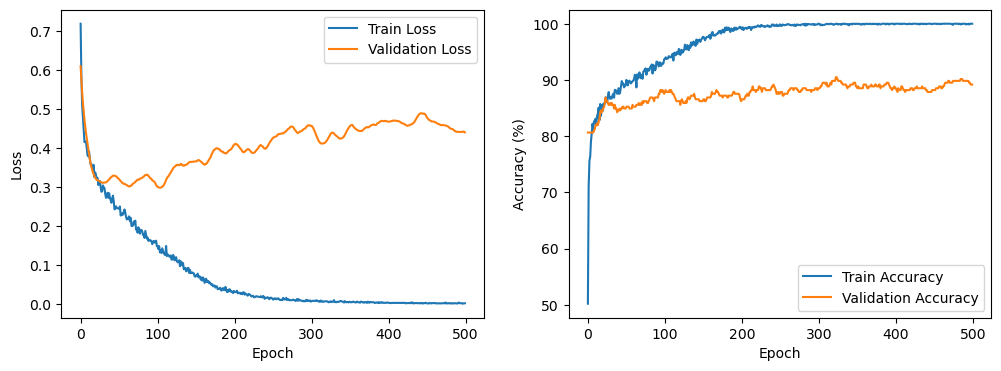

In [25]:
num_epochs = 500
train_losses = []
train_accuracies = []
val_losses = []
val_accuracies = []



for epoch in range(num_epochs):
    model.train()
    total_train_loss = 0.0
    correct_train = 0
    total_train = 0

    for seqs, labels in train_loader:
        seqs, labels = seqs.to(device), labels.to(device)
        labels_softmax = torch.cat([labels.view(-1, 1)==0, labels.view(-1, 1)==1], dim=1).float()
        optimizer.zero_grad()
        outputs = model(seqs + torch.randn_like(seqs)/200)
        loss = criterion(outputs, labels_softmax)
        loss.backward()
        optimizer.step()

        total_train_loss += loss.item()
        _, predicted = outputs.max(1)
        total_train += labels.size(0)
        correct_train += predicted.eq(torch.argmax(labels_softmax, dim=1)).sum().item()

    train_accuracy = 100 * correct_train / total_train
    avg_train_loss = total_train_loss / len(train_loader)
    train_losses.append(avg_train_loss)
    train_accuracies.append(train_accuracy)

    

    model.eval()
    total_val_loss = 0.0
    correct_val = 0
    total_val = 0

    with torch.no_grad():
        for seqs, labels in val_loader:
            seqs, labels = seqs.to(device), labels.to(device)
            labels_softmax = torch.cat([labels.view(-1, 1)==0, labels.view(-1, 1)==1], dim=1).float()
            val_outputs = model(seqs)
            val_loss = criterion(val_outputs, labels_softmax)

            total_val_loss += val_loss.item()
            _, predicted_val = val_outputs.max(1)
            total_val += labels.size(0)
            correct_val += predicted_val.eq(torch.argmax(labels_softmax, dim=1)).sum().item()

    val_accuracy = 100 * correct_val / total_val
    avg_val_loss = total_val_loss / len(val_loader)
    val_losses.append(avg_val_loss)
    val_accuracies.append(val_accuracy)

    if (100 * (epoch+1) / num_epochs) % 10 == 0:
        print(f"Epoch [{epoch + 1}/{num_epochs}] - "
            f"Train Loss: {avg_train_loss:.4f}, "
            f"Train Accuracy: {train_accuracy:.2f}%, "
            f"Validation Loss: {avg_val_loss:.4f}, "
            f"Validation Accuracy: {val_accuracy:.2f}%")
    torch.save(model, f'./models/BiLSTMmodel_{epoch+1}.pth')

# Plotting
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(train_accuracies, label='Train Accuracy')
plt.plot(val_accuracies, label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.legend()

plt.show()


In [29]:
# Evaluate the model
best_model = torch.load('./models/BiLSTMmodel_300.pth').to(device)
torch.save(best_model, 'best_model_BiLSTM.pth')
best_model.eval()
with torch.no_grad():

    accuracy = 0
    for seqs, labels in test_loader:
        
        seqs, labels = seqs.to(device), labels.to(device)
        test_outputs = best_model(seqs)
        predicted_labels = torch.argmax(test_outputs, axis=1)
        
        accuracy += torch.sum(predicted_labels == labels).item() / len(labels) / len(test_loader)
    print("Accuracy on the test data:", f'{accuracy*100:.2f}')

Accuracy on the test data: 90.55


As we can see, there is a bit more capacity in BiLSTM, so it fits completely to train data, but in test we can see no really big difference

### Comparison model accuracy for different lengths of embeddings

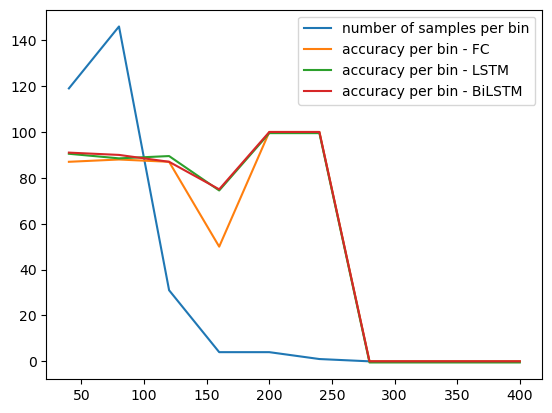

In [74]:
best_model_fc = torch.load('best_model_fc.pth').to(device)
best_model_LSTM = torch.load('best_model_LSTM.pth').to(device)
best_model_BiLSTM = torch.load('best_model_BiLSTM.pth').to(device)

ranges = np.linspace(0, 400, 11)[1:]

test_dataset.lengths = True
test_dataset_bins = [[] for _ in range(10)]
bins = [0] * 10
corrects_FC = [0] * 10
corrects_LSTM = [0] * 10
corrects_BiLSTM = [0] * 10
for j in range(len(test_dataset)):
    seq, label, leng = test_dataset[j]
    seq = seq.to(device)
    for i, r in enumerate(ranges):  
        if leng < r:
            output = torch.argmax(best_model_fc(torch.flatten(seq).unsqueeze(0))).item()
            corrects_FC[i] += 1 if output == label else 0

            output = torch.argmax(best_model_LSTM(seq)).item()
            corrects_LSTM[i] += 1 if output == label else 0

            output = torch.argmax(best_model_BiLSTM(seq)).item()
            corrects_BiLSTM[i] += 1 if output == label else 0
            bins[i]+=1
            break
bins = np.array(bins)
corrects_FC = np.array(corrects_FC)
corrects_LSTM = np.array(corrects_LSTM)
corrects_BiLSTM = np.array(corrects_BiLSTM)

acc_FC = np.zeros_like(bins)
acc_FC[np.array(bins) != 0] = corrects_FC[np.array(bins) != 0] / bins[np.array(bins) != 0] * 100
acc_FC[np.array(bins) == 0] = 0

acc_LSTM = np.zeros_like(bins)
acc_LSTM[np.array(bins) != 0] = corrects_LSTM[np.array(bins) != 0] / bins[np.array(bins) != 0] * 100
acc_LSTM[np.array(bins) == 0] = 0

acc_BiLSTM = np.zeros_like(bins)
acc_BiLSTM[np.array(bins) != 0] = corrects_BiLSTM[np.array(bins) != 0] / bins[np.array(bins) != 0] * 100
acc_BiLSTM[np.array(bins) == 0] = 0

plt.plot(ranges, bins, label = 'number of samples per bin')
plt.plot(ranges, acc_FC, label = 'accuracy per bin - FC')
plt.plot(ranges, acc_LSTM-0.5, label = 'accuracy per bin - LSTM')
plt.plot(ranges, acc_BiLSTM, label = 'accuracy per bin - BiLSTM')
plt.legend()
plt.show()

As we can see, LSTM and also BiLSTM, behaves more robust with input and accuracy in all bins are closer together. but in FC we can see that it depends on molecule length. its because LSTM learns real features but FC cant.